In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import utm
import warnings
import geopandas as gpd
import contextily as ctx


In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.0f}'.format
sns.set_style("whitegrid")

In [3]:
dt = pd.read_csv(r'C:\Users\Taha\Desktop\Folder\QBTC-Divar-Project\Datas\Divar.csv', dtype={11: str, 27: str, 29: str, 53: str})

Data: 1000000
Data Cleaned: 581625
Features: ['ppm', 'building_size', 'rooms', 'score', 'year', 'map_x', 'map_y']
                ppm  building_size  year  score
cluster                                        
3         8,175,983          1,196 1,395      0
7        12,355,408            215 1,396      0
0        16,807,591            152 1,395      1
6        18,207,536            128 1,396      2
8        18,317,687             75 1,396      0
1        24,429,179             96 1,399      3
2        24,583,766            106 1,387      2
5        26,411,510             70 1,382      1
9        27,957,517            183 1,399      3
4       143,113,134            125 1,394      2


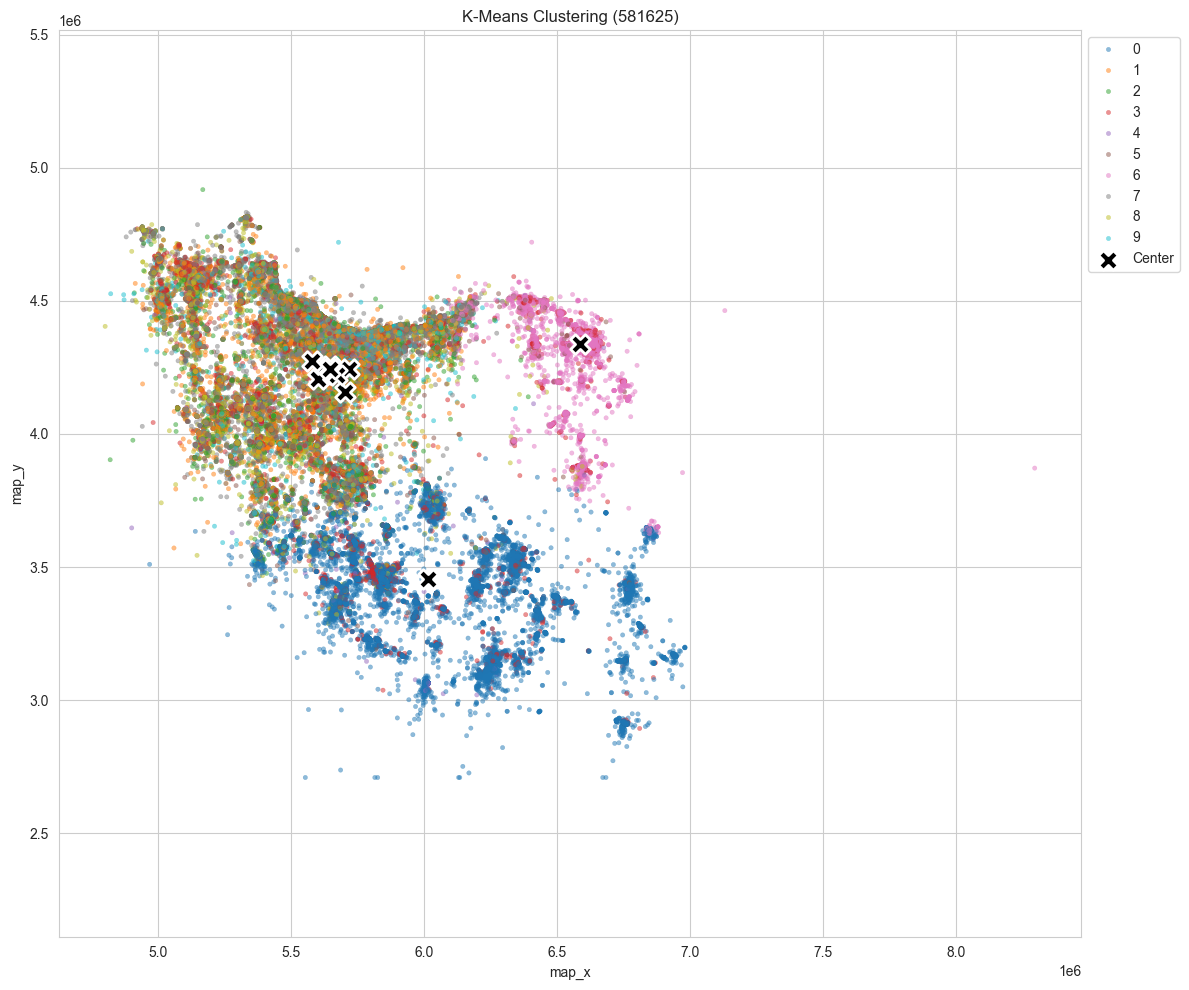

In [4]:
dt = dt.copy()
print(f'Data: {len(dt)}')
digits = {'۰':'0','۱':'1','۲':'2','۳':'3','۴':'4','۵':'5','۶':'6','۷':'7','۸':'8','۹':'9'}
words = {'بدون اتاق': 0, 'یک': 1, 'دو': 2, 'سه': 3, 'چهار': 4, 'پنج': 5, 'شش': 6, 'هفت': 7, 'هشت': 8, 'نه': 9, 'ده': 10}

amenity = ['has_parking', 'has_elevator', 'has_warehouse']
valid_opts = [c for c in amenity if c in dt.columns]
dt[valid_opts] = dt[valid_opts].fillna(False).astype(int)
dt['score'] = dt[valid_opts].sum(axis=1)

num_cols = ['price_value', 'credit_value', 'rent_value', 'building_size']
for c in num_cols:
    if c in dt.columns:
        dt[c] = pd.to_numeric(dt[c].astype(str).replace(digits, regex=True), errors='coerce')

if 'rent_value' in dt.columns: dt['rent_value'] = dt['rent_value'].fillna(0)
dt['price'] = dt.get('price_value', np.nan)

if 'credit_value' in dt.columns and 'rent_value' in dt.columns:
    mask = dt['price'].isna()
    dt.loc[mask, 'price'] = dt.loc[mask, 'credit_value'] + (dt.loc[mask, 'rent_value'] * 30)

if 'construction_year' in dt.columns:
    dt['year'] = pd.to_numeric(dt['construction_year'].astype(str).replace(digits, regex=True), errors='coerce')
    dt.loc[~dt['year'].between(1300, 1410), 'year'] = np.nan

if 'rooms_count' in dt.columns:
    dt['rooms'] = dt['rooms_count'].map(words)
    mask_nan = dt['rooms'].isna()
    dt.loc[mask_nan, 'rooms'] = pd.to_numeric(dt.loc[mask_nan, 'rooms_count'].astype(str).replace(digits, regex=True), errors='coerce')

req = ['price', 'building_size', 'location_latitude', 'location_longitude']
clean = dt.dropna(subset=[c for c in req if c in dt.columns]).copy()
clean = clean[clean['building_size'].between(10, 2000)]

clean['ppm'] = clean['price'] / clean['building_size']
q_l, q_h = clean["ppm"].quantile([0.01, 0.99])
clean = clean[clean["ppm"].between(q_l, q_h)]

print(f"Data Cleaned: {len(clean)}")

gdf = gpd.GeoDataFrame(clean, geometry=gpd.points_from_xy(clean['location_longitude'], clean['location_latitude']), crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:3857")

clean['map_x'] = gdf.geometry.x
clean['map_y'] = gdf.geometry.y

candidates = ['ppm', 'building_size', 'rooms', 'score', 'year', 'map_x', 'map_y']
feats = [f for f in candidates if f in clean.columns and clean[f].notna().mean() > 0.5]
print(f"Features: {feats}")

X = clean[feats].copy()
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X)
scaler = StandardScaler()
X_scl = scaler.fit_transform(X_imp)

kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clean['cluster'] = kmeans.fit_predict(X_scl)

stats = clean.groupby('cluster')[['ppm', 'building_size', 'year', 'score']].mean().sort_values('ppm')
print(stats)

centers = clean.groupby('cluster')[['map_x', 'map_y']].mean()

plt.figure(figsize=(12, 10))
sns.scatterplot(data=clean, x='map_x', y='map_y', hue='cluster', palette='tab10', s=10, alpha=0.5, edgecolor=None)
plt.scatter(centers['map_x'], centers['map_y'], c='black', s=200, marker='X', label='Center', edgecolor='white', linewidth=2, zorder=10)

plt.title(f'K-Means Clustering ({len(clean)})')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()